#**Importing Libraries**

In [ ]:
import numpy as np 
import pandas as pd 

from glob import glob
import os
import matplotlib.pyplot as plt
import shutil
import torchvision
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
%matplotlib inline

In [ ]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True


In [ ]:
transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

valid = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)


In [ ]:
print(train.class_to_idx)
print(train.classes)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 500)
        self.fc2 = nn.Linear(500,50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)



In [ ]:
model = Net()
if is_cuda:
    model.cuda()

In [ ]:
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [ ]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data) #forward
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()    #backward
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [ ]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   2.0 and training accuracy is 13609/50000     27.22
validation loss is   1.7 and validation accuracy is 3957/10000     39.57
training loss is   1.8 and training accuracy is 17012/50000     34.02
validation loss is   1.7 and validation accuracy is 4486/10000     44.86
training loss is   1.8 and training accuracy is 18262/50000     36.52
validation loss is   1.6 and validation accuracy is 4579/10000     45.79
training loss is   1.7 and training accuracy is 19712/50000     39.42
validation loss is   1.5 and validation accuracy is 4844/10000     48.44
training loss is   1.6 and training accuracy is 20698/50000      41.4
validation loss is   1.5 and validation accuracy is 5024/10000     50.24
training loss is   1.6 and training accuracy is 21416/50000     42.83
validation loss is   1.5 and validation accuracy is 5004/10000     50.04
training loss is   1.6 and training accuracy is 22305/50000     44.61
validation loss is   1.4 and validation accuracy is 5318/10000     53.18

# **Plotting**

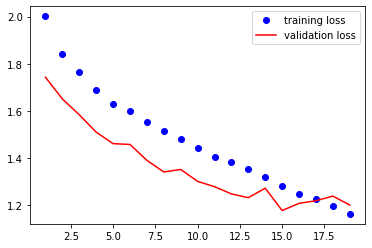

In [ ]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

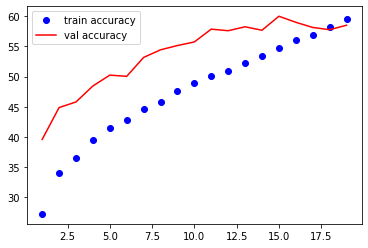

In [ ]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

# **VGG16**

In [ ]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg.classifier[6].out_features = 10
for param in vgg.features.parameters(): param.requires_grad = False

In [ ]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [ ]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)         #forward
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()         # backward
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [ ]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   3.7 and training accuracy is 13591/50000     27.18
validation loss is   1.3 and validation accuracy is 6055/10000     60.55
training loss is   1.2 and training accuracy is 29862/50000     59.72
validation loss is  0.88 and validation accuracy is 7184/10000     71.84
training loss is  0.95 and training accuracy is 33813/50000     67.63
validation loss is  0.75 and validation accuracy is 7546/10000     75.46
training loss is  0.84 and training accuracy is 35658/50000     71.32
validation loss is  0.68 and validation accuracy is 7735/10000     77.35
training loss is  0.77 and training accuracy is 36844/50000     73.69
validation loss is  0.63 and validation accuracy is 7855/10000     78.55
training loss is  0.71 and training accuracy is 37615/50000     75.23
validation loss is   0.6 and validation accuracy is 7940/10000      79.4
training loss is  0.68 and training accuracy is 38287/50000     76.57
validation loss is  0.58 and validation accuracy is 7998/10000     79.98

In [ ]:
for layer in vgg.classifier.children():
    if(type(layer) == nn.Dropout):
        layer.p = 0.2

In [ ]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.52 and training accuracy is 40965/50000     81.93
validation loss is  0.53 and validation accuracy is 8140/10000      81.4
training loss is  0.51 and training accuracy is 41153/50000     82.31
validation loss is  0.52 and validation accuracy is 8189/10000     81.89


# **Data Augmentation**

In [ ]:
train_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.RandomHorizontalFlip()
                                       ,transforms.RandomRotation(0.2)
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

valid = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=train_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data_loader = DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

In [ ]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   0.5 and training accuracy is 41216/50000     82.43
validation loss is   0.5 and validation accuracy is 8257/10000     82.57
training loss is  0.49 and training accuracy is 41371/50000     82.74
validation loss is   0.5 and validation accuracy is 8265/10000     82.65
